In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms


In [2]:
np.random.seed(100)

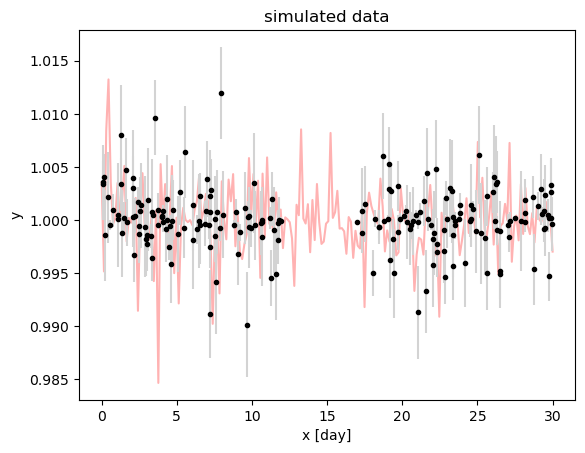

In [3]:
#2 minute cadence = 720 samples in 1 day 

t = np.sort(np.append(
        np.random.uniform(0, 12, 100), 
        np.random.uniform(17, 30, 100),
    ))  # The input coordinates must be sorted
yerr = np.random.uniform(0.0001, 0.005, len(t))
y = (1 + 0.00001*np.sin(t + 6) + yerr * np.random.randn(len(t)))

true_t = np.linspace(0, 30, len(t))
true_y = (1 + 0.0000001*np.sin(true_t + 6) + yerr * np.random.randn(len(true_t)))

plt.plot(true_t, true_y, lw=1.5, alpha=0.3, color="r", zorder=0)
plt.errorbar(t, y, yerr=yerr, fmt=".", color="black", ecolor="LightGrey", capsize=0, zorder=100)
plt.xlabel("x [day]")
plt.ylabel("y")
_ = plt.title("simulated data")


In [4]:
def set_params(params, yerrs):
    _sigma, _rho = params
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    gp = celerite2.GaussianProcess(kernel, mean=0.0,)
    gp.compute(t, yerr=yerrs, quiet=True)

    return gp

In [5]:
def plot(parmas):

    gp = set_params(parmas, yerr)
    gp.compute(t, yerr=yerr)

    conditional = gp.condition(y, true_t)

    plt.plot(true_t, conditional.sample(), color="C1")
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    plt.ylim(0.95, 1.05)
    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.show()
    


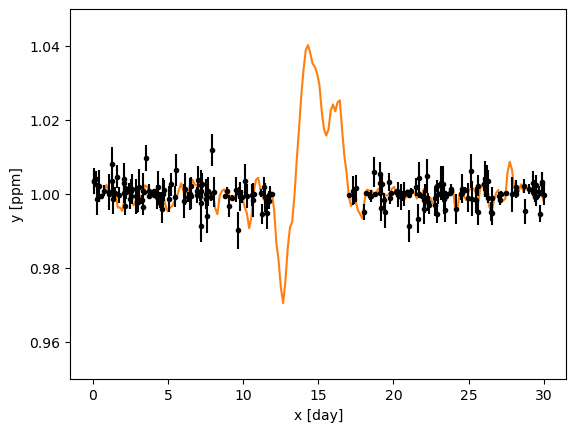

In [6]:
plot([100, 1000])

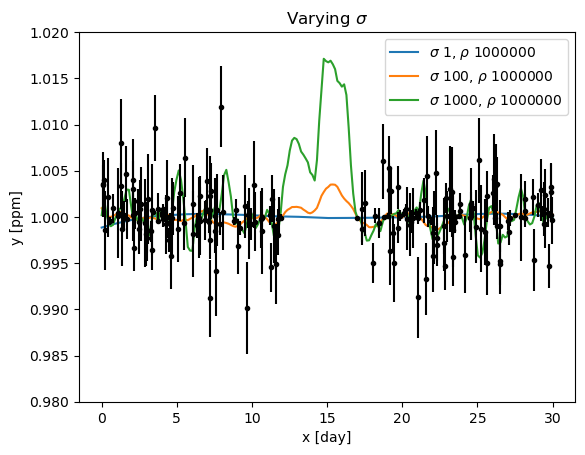

In [7]:
param_list = [[1, 1000000], [100, 1000000], [1000, 1000000]]

for params in param_list: 
    gp = set_params(params, yerr)
    gp.compute(t, yerr=yerr)

    conditional = gp.condition(y, true_t)
    label = "$\sigma$ %s, $\\rho$ %s" % (params[0], params[1]) 
    plt.plot(true_t, conditional.sample(), label=label)

plt.title("Varying $\sigma$")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.ylim(0.98, 1.02)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.legend()
plt.show()

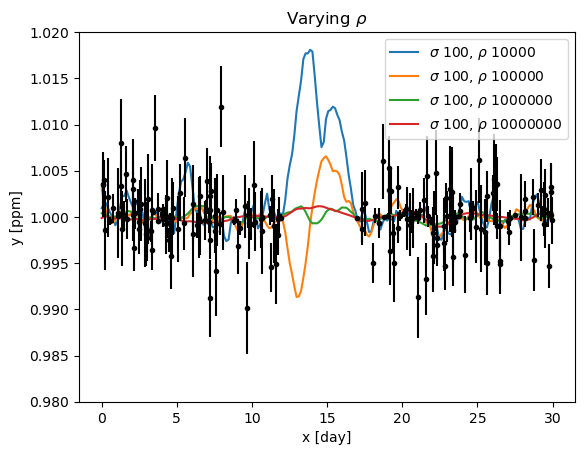

In [8]:
param_list = [[100, 10000], [100, 100000], [100, 1000000], [100, 10000000]]

for params in param_list: 
    gp = set_params(params, yerr)
    gp.compute(t, yerr=yerr)

    conditional = gp.condition(y, true_t)
    label = "$\sigma$ %s, $\\rho$ %s" % (params[0], params[1]) 
    plt.plot(true_t, conditional.sample(), label=label)

plt.title("Varying $\\rho$")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.ylim(0.98, 1.02)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.legend()
plt.show()

In [9]:
def set_params(params, yerrs):
    _sigma, _rho = params
    kernel = terms.Matern32Term(sigma = _sigma, rho  = _rho)
    
    gp = celerite2.GaussianProcess(kernel, mean=0.0,)
    gp.compute(t, yerr=yerrs, quiet=True)

    return gp

In [15]:
def log_likelihood(prior_params, flux_data, yerrs):
    
    gp = set_params(prior_params, yerrs)

    prob = gp.log_likelihood(flux_data)
    return prob


def log_prior(prior_params):
    _sigma, _rho = prior_params

    prob = 0.0
    if _sigma < -1E6 or _sigma > 1E6:
        prob += -np.inf
        return prob
    
    if _rho < 0 or _rho > 1E6:
        prob += -np.inf
        return prob
    
    return prob


def log_prob(prior_params, flux_data, yerrs):
    lp = log_prior(prior_params)
    if (np.isinf(lp) == True):
        return -np.inf

    return log_likelihood(prior_params, flux_data, yerrs) + lp

In [14]:
guess = [100, 100000]

pos = guess + 1E-8 * np.random.randn(20, len(guess))
nwalkers, ndim = pos.shape


with Pool() as pool:
    start_time = time.time()
    print("Start:       {}".format(time.ctime(int(start_time))))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(y, yerr))
    sampler.run_mcmc(pos, 10000, progress=True)

    end_time = time.time()
    execution_time = (end_time - start_time)
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))

Start:       Tue Feb  7 11:54:38 2023


  2%|▏         | 218/10000 [00:01<00:41, 233.86it/s]Traceback (most recent call last):
  File "c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_2632\3345806500.py", line 29, in log_prob
    return log_likelihood(prior_params, flux_data, yerrs) + lp
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_2632\3345806500.py", line 5, in log_likelihood
    prob = gp.log_likelihood(flux_data)
  File "c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\celerite2\core.py", line 427, in log_likelihood
    return self._norm - 0.5 * self._do_norm(y - self._mean_value)
  File "c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\celerite2\numpy.py", line 106, in _do_norm
    self._t, self._c, self._U, self._W, alpha, alpha
AttributeError: 'GaussianProcess' object has no attribute '_W'
  2%|▏         | 224/10000 [00:01<00:

emcee: Exception while calling your likelihood function:
  params: [   4.83198772 -449.63442626]
  args: (array([1.00343497, 1.00355151, 1.00402329, 0.9985526 , 1.00212121,
       0.999524  , 1.00091496, 1.00043101, 1.0001127 , 1.00336211,
       1.00797734, 0.99873415, 1.00019977, 1.0046863 , 0.99977116,
       1.00302273, 1.00398596, 1.00025921, 0.99667823, 1.0004061 ,
       1.00167249, 0.99872661, 0.99943607, 1.00080668, 1.0014107 ,
       0.99937432, 0.99818857, 0.99854613, 0.99770069, 1.00193071,
       0.99846158, 0.99637748, 1.0007858 , 1.00051007, 1.00962263,
       0.99955617, 1.00089948, 1.00024435, 1.00037818, 1.00080366,
       0.99978928, 0.99919148, 1.0000148 , 1.00199545, 0.99749623,
       0.999409  , 0.99581679, 0.99989941, 1.00093036, 0.99868838,
       1.00262757, 0.99929079, 1.0064246 , 0.99815528, 1.00138192,
       0.99911648, 0.99991505, 1.00221593, 0.99952349, 0.99964079,
       1.00082166, 1.00389035, 0.99948706, 1.00229714, 0.99118621,
       1.00070916, 0.99

AttributeError: 'GaussianProcess' object has no attribute '_W'

In [12]:
samples = sampler.get_chain()
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [231.99762583 100.96258519]

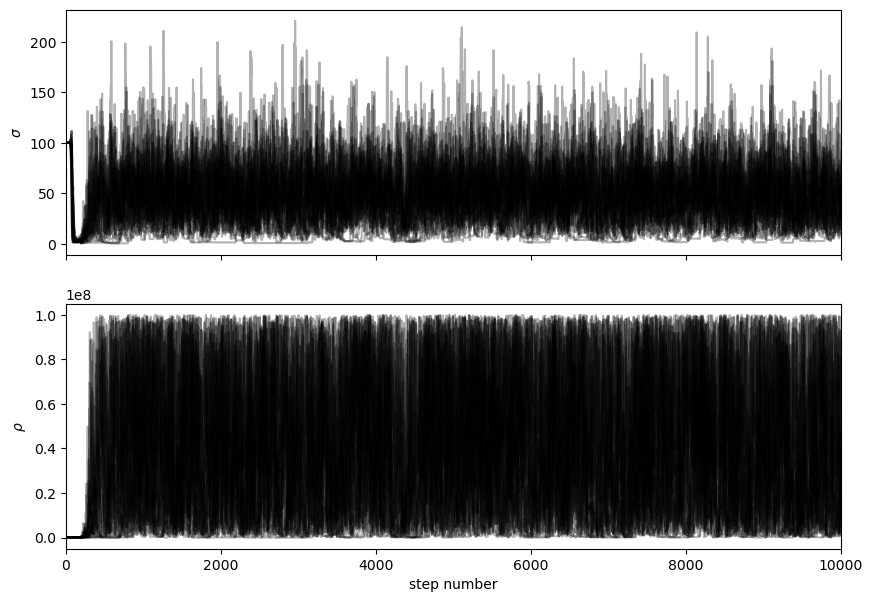

In [ ]:
fig, axes = plt.subplots(len(guess), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\\sigma$", "$\\rho$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number")
plt.show()

In [ ]:
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(flat_samples.shape)

(3680, 2)


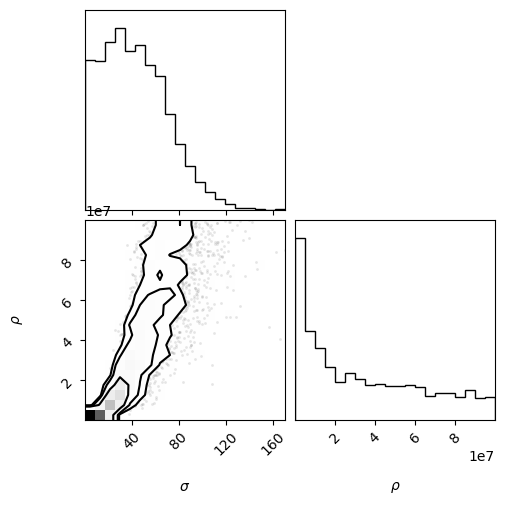

In [ ]:
fig = corner.corner(
    flat_samples, labels=labels)
